## Overview

This notebook is used to preprocess raw historical data and to output it in a more condensed format that can later be used by the ML and DO models

**The following data assets are used as input**:

* historical-machine.csv
* historical-production.csv
* historical-failure.csv

**The following data set is generated as output**:

* historical.csv

For detailed descriptions of the data assets please see the README file.  Please also note that this project includes a pre-generated historical.csv that should be used for the purposes of this demo.  This notebook is included for completeness to demonstrate the preprocessing step that is often necessary in a real world situation.

Import machine data:

Column | Description
----- | -----------
id | machine ID
capacity | production capacity in units/day
remaining life | days before failure for this machine, according to vendor specification
cost of maintenance | cost of maintenance (performed before machine fails)
maintenance loss | percent of production capacity lost on the day of maintenance (performed before machine fails)
cost of repair | cost of unplanned maintenance (performed after machine fails)
repair loss | percent of production capacity lost on the day of repair, if repair occurs
loss per life day | opportunity cost per day incurred due to 'unused' life days, when maintenance is performed sooner than remaining life
production value unit | value of each unit produced



Before executing this notebook on IBM Cloud , you need to:<br>
1) When you import this project on an IBM Cloud environment, a project access token should be inserted at the top of this notebook as a code cell. <br>
If you do not see the cell above, Insert a project token: Click on **More -> Insert project token** in the top-right menu section and run the cell <br>
![ws-project.mov](https://media.giphy.com/media/jSVxX2spqwWF9unYrs/giphy.gif)
2) Provide your IBM Cloud API key in the subsequent cell<br>
3) You can then step through the notebook execution cell by cell, by selecting Shift-Enter. Or you can execute the entire notebook by selecting **Cell -> Run All** from the menu.<br>

In [2]:
import os, pandas as pd

# Click the option "Insert project token" by selecting the three dots in the top bar
try:
    project
except NameError:
    # READING AND WRITING PROJECT ASSETS
    import project_lib
    project = project_lib.Project()  

df_machine = pd.read_csv(project.get_file('historical-machine.csv'))
df_machine.head()

id  capacity  remaining life  cost of maintenance  maintenance loss  \
0  M-01       130              15                   50                50   
1  M-02       100               9                   50                50   
2  M-03       140               8                   50                50   
3  M-04       140               6                   50                50   
4  M-05       130              12                   50                50   

   cost of repair  repair loss  loss per life day  production value unit  
0             100          100                 20                     10  
1             100          100                 20                     10  
2             100          100                 20                     10  
3             100          100                 20                     10  
4             100          100                 20                     10

Gather the data we need in separate data frames to be joined later. Only keep the columns we need for each data frame.  For machine data it is just `id` and `remaining life`. Rename `remaining life` to `life`

In [3]:
df_machine = df_machine[['id', 'remaining life']];
df_machine.columns = ['id', 'life']
df_machine = df_machine.set_index(['id'])
df_machine.head()

life
id        
M-01    15
M-02     9
M-03     8
M-04     6
M-05    12

Read in production data in the following format:

Machine ID | Day | Planned production (in units)
---------- | --- | -----------------------------
M-01 | Day-01 | 88
M-01 | Day-02 | 104
...  | ...    | ...
M-01 | Day-15 | 118

and use pivot to group production numbers by machine:

Machine ID | Day-01 | Day-02 | ... | Day-15
---------- | ------ | ------ | --- | ------
M-01 | 88 | 104 | ... | 118

In [4]:
df_production = pd.read_csv(project.get_file('historical-production.csv'))
df_production.columns = ['id', 'day', 'production']
df_production = df_production.pivot(index='id', columns='day', values='production')
df_production.head()

day   Day-01  Day-02  Day-03  Day-04  Day-05  Day-06  Day-07  Day-08  Day-09  \
id                                                                             
M-01      88     104     126      94     103     107     126      95     105   
M-02     121      96     101      98      97      93     132     118     108   
M-03      90      95     120     126     120     113     116     133     125   
M-04      72      60      56      65      57      64      74      84      80   
M-05      74      67      65      74      72      73      80      80      80   

day   Day-10  Day-11  Day-12  Day-13  Day-14  Day-15  
id                                                    
M-01     120      88     114     126      90     118  
M-02     139     115     125     120     129     119  
M-03     125     106     129      96      99      93  
M-04      84      64      65      80      70      64  
M-05      80      80      61      80      80      80

Read in historical failure rates, i.e. how many times a given machine has failed on a given day

In [5]:
df_failure = pd.read_csv(project.get_file('historical-failure.csv'))
df_failure.columns = ['id', 'day', 'failure']
df_failure.head(15)

id     day  failure
0   M-01  Day-01        0
1   M-01  Day-02        0
2   M-01  Day-03        0
3   M-01  Day-04        0
4   M-01  Day-05        0
5   M-01  Day-06        0
6   M-01  Day-07        0
7   M-01  Day-08        0
8   M-01  Day-09        0
9   M-01  Day-10        0
10  M-01  Day-11        0
11  M-01  Day-12        3
12  M-01  Day-13       24
13  M-01  Day-14       46
14  M-01  Day-15       25

For each machine, determine `mid`, the index of day which corresponds to the highest failure rate:

In [6]:
machines = df_machine.index.values
mid_data = [];
for m in machines:
    max_index = -1;
    max_value = 0;
    failure = df_failure[df_failure.id == m].reset_index();
    for (i, r) in failure.iterrows():
        if (r.failure > max_value):
            max_index = i+1;
            max_value = r.failure;
    mid_data.append([m, max_index])

df_mid = pd.DataFrame(data=mid_data, columns=['id', 'mid']);
df_mid = df_mid.set_index(['id']) 
df_mid.head()

mid
id       
M-01   14
M-02    9
M-03    4
M-04    6
M-05    6

Join the generated data frames to obtain a table with historical data that can be used by an ML model to train a linear regression classifier that predicts failure:

In [7]:
df_historical = df_machine.join(df_production).join(df_mid)
df_historical.head()

life  Day-01  Day-02  Day-03  Day-04  Day-05  Day-06  Day-07  Day-08  \
id                                                                           
M-01    15      88     104     126      94     103     107     126      95   
M-02     9     121      96     101      98      97      93     132     118   
M-03     8      90      95     120     126     120     113     116     133   
M-04     6      72      60      56      65      57      64      74      84   
M-05    12      74      67      65      74      72      73      80      80   

      Day-09  Day-10  Day-11  Day-12  Day-13  Day-14  Day-15  mid  
id                                                                 
M-01     105     120      88     114     126      90     118   14  
M-02     108     139     115     125     120     129     119    9  
M-03     125     125     106     129      96      99      93    4  
M-04      80      84      64      65      80      70      64    6  
M-05      80      80      80      61      80      80      80    6

Plot life vs mid.  Note that there is some variation - based on historical data, a machine is likely to fail a number of days earlier than specified by the vendor, and in some cases a day later.

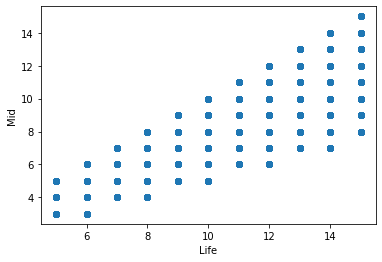

In [8]:
from matplotlib import pyplot as plt
import numpy as np

x = list_of_names = df_historical['life'].to_list()
y = list_of_names = df_historical['mid'].to_list()
plt.scatter(x,y)
plt.xlabel("Life")
plt.ylabel("Mid")
plt.show()

Write out the output as a data set. In this notebook we have shown how to preprocess historical data and prepare it for input into an ML model.  historical.csv has already been generated for you and is part of the data assets in this project. 

In [9]:
df_historical = df_historical.reset_index(drop=True)
project.save_data('historical.csv', df_historical.to_csv(index=False), overwrite=True)

{'file_name': 'historical.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'intelligentmaintenace-donotdelete-pr-oig7f6npdagctl',
 'asset_id': '60095b64-9f95-432e-9094-13fe6107ff96'}

## Terms and Conditions
This project contains Sample Materials, provided under this <a href="https://github.com/IBM/Industry-Accelerators/blob/master/CPD%20SaaS/LICENSE" target="_blank" rel="noopener noreferrer">license</a>. <br/>
Licensed Materials - Property of IBM. <br/>
© Copyright IBM Corp. 2019, 2021. All Rights Reserved. <br/>
US Government Users Restricted Rights - Use, duplication or disclosure restricted by GSA ADP Schedule Contract with IBM Corp.<br/>